In [1]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
import json

## Data Analysis on Secondary

In [2]:
# set this to either primary or secondary depending on the analysis you want to do
dataset = 'secondary'

mappings = json.load(open(f'../dataset/mapping_{dataset}.json'))
data = pd.read_csv(f'../dataset/mapped_{dataset}.csv')

In [3]:
# drop the uuid column as it isn't a guantitative value
data = data.select_dtypes(include=['number'])
print(data.describe())

               price         artist     cardFinish  colorIdentity  \
count  228637.000000  228637.000000  228637.000000  228637.000000   
mean        0.739998     674.922978       1.694048      19.461102   
std         1.007018     402.720325       0.476893      10.588725   
min         0.010000       0.000000       0.000000       0.000000   
25%         0.120000     298.000000       1.000000      16.000000   
50%         0.350000     637.000000       2.000000      24.000000   
75%         0.800000    1027.000000       2.000000      29.000000   
max         4.730000    1398.000000       2.000000      31.000000   

              colors     edhrecRank  edhrecSaltiness  gameAvailability  \
count  228637.000000  228637.000000    228637.000000     228637.000000   
mean       19.517974   10295.519859         0.293477          0.807083   
std        10.532966    7913.381637         0.263940          0.394589   
min         0.000000       1.000000         0.010000          0.000000   
25%     

In [4]:
# plot function 
def plot(data, type, color=plt.cm.viridis(0.2), bins=None, lim=None, mapping_dict=None):
    """Creates plots for the quantitative DataFrame
    Args:
        - data: dataframe
        - type: type of plot (hist, box)
        - color: plot color
        - bins: number of bins in this hist
        - lim: optional bound for graph
    """
    # subplot calcuations for size
    num = len(data.columns)
    ncols = 2
    nrows = int(np.ceil(num / ncols))

    # size based on nrows
    plt.figure(figsize=(12, 5*nrows))

    for i, column in enumerate(data.columns):      
        plt.subplot(nrows,ncols,i+1)
        if type == "hist":
            plt.hist(data[column], color = color, bins=bins)
            plt.title(f"Histogram of {column}")
            plt.ylabel("Frequency")
            plt.xlabel("Value")
            if lim:
                plt.title(f"Histogram of {column} bounded under {lim}")
                plt.xlim(0,lim)

        elif type == "box":
            if bins == 2 and column != "price":
                sns.boxplot(x = column, y = "price", data = data)
                plt.ylabel("price")
            else:
                plt.boxplot(data[column], whis=lim, patch_artist=True)
                plt.ylabel("Value")
            plt.title(f"Box Plot of {column}")
            if lim:
                plt.ylim(0,lim)
    plt.show()

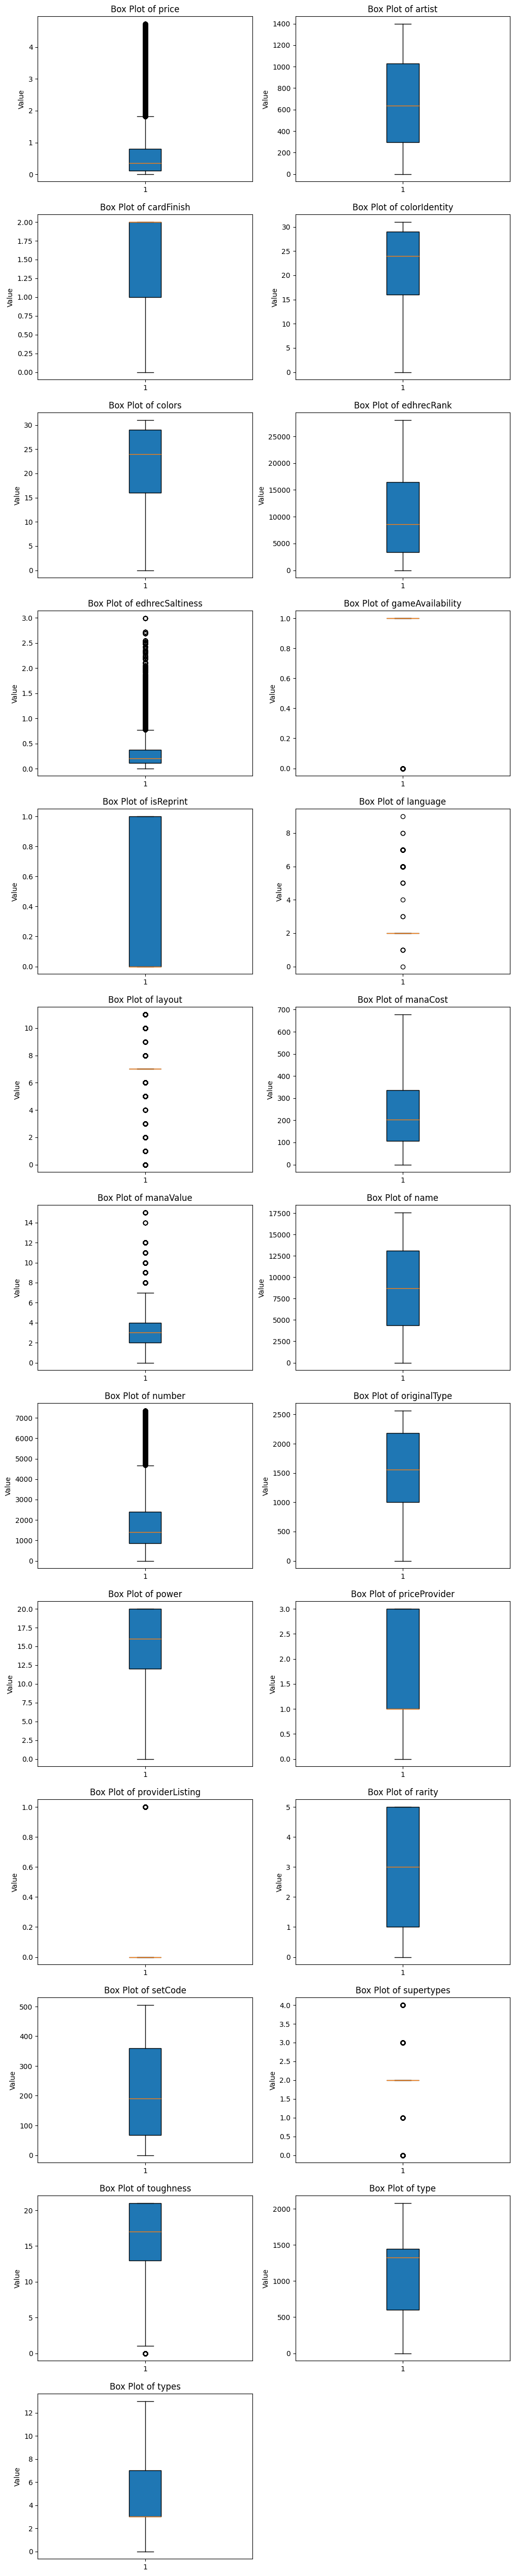

In [5]:
plot(data, "box")

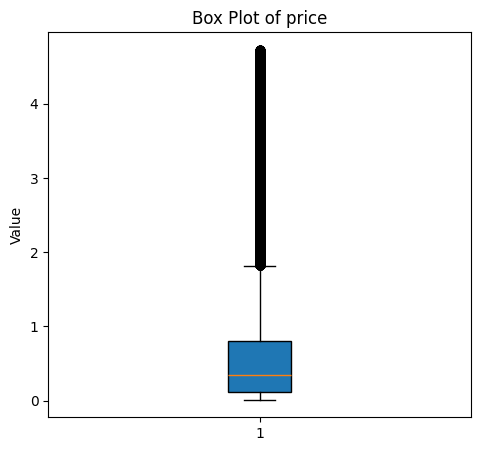

In [6]:
plot(data[["price"]], "box")

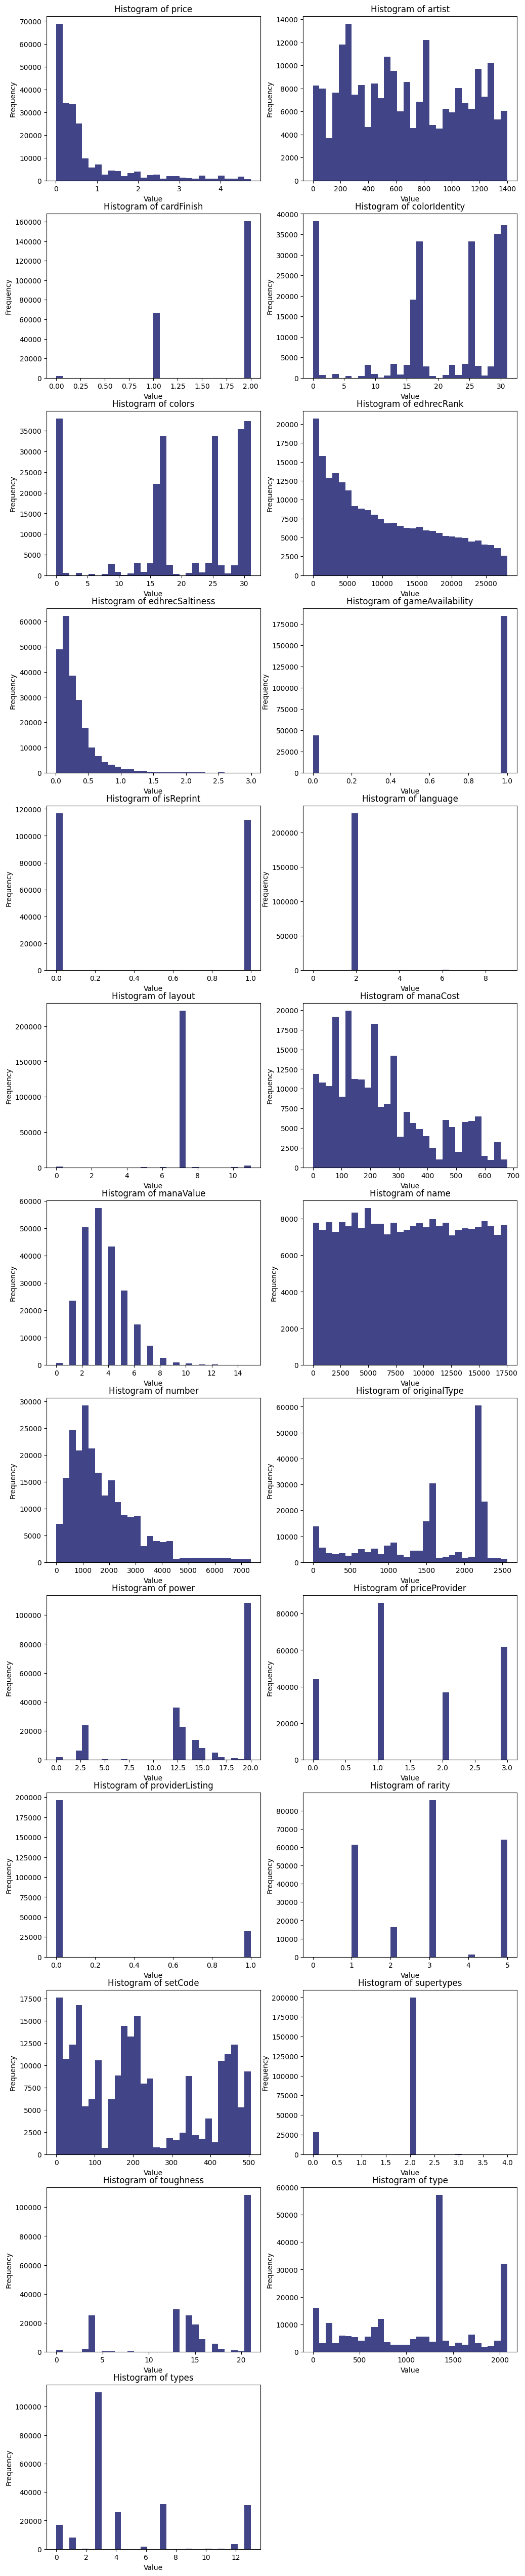

In [7]:
plot(data, "hist", bins=30)

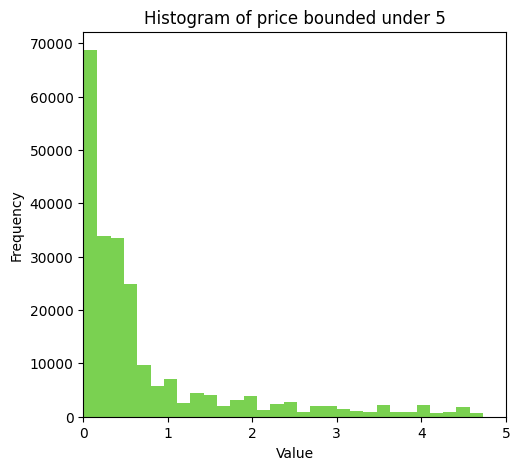

count    228637.000000
mean          0.739998
std           1.007018
min           0.010000
25%           0.120000
50%           0.350000
75%           0.800000
max           4.730000
Name: price, dtype: float64


In [8]:
plot(data[["price"]], "hist", plt.cm.viridis(0.8), bins=30, lim=5)
print(data['price'].describe())

In [9]:
# Correlations
def corr(data, dataset):
    """Plot correlation between variables in a dataframe
    Args:
        - data: dataframe
    """
    correlation_matrix = data.corr()
    
    # get price to be the first variable
    ordered = ['price'] + [col for col in correlation_matrix.columns if col != 'price']
    ordered_correlation_matrix = correlation_matrix.loc[ordered, ordered]

    plt.figure(figsize=(15,15))
    sns.heatmap(ordered_correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', square=True, linewidths=0.5)
    plt.title(f"{dataset} Correlation Heatmap of Variables")
    plt.savefig(f'../dataset/graphs/Correlation_{dataset}.png', format='png')
    plt.show()

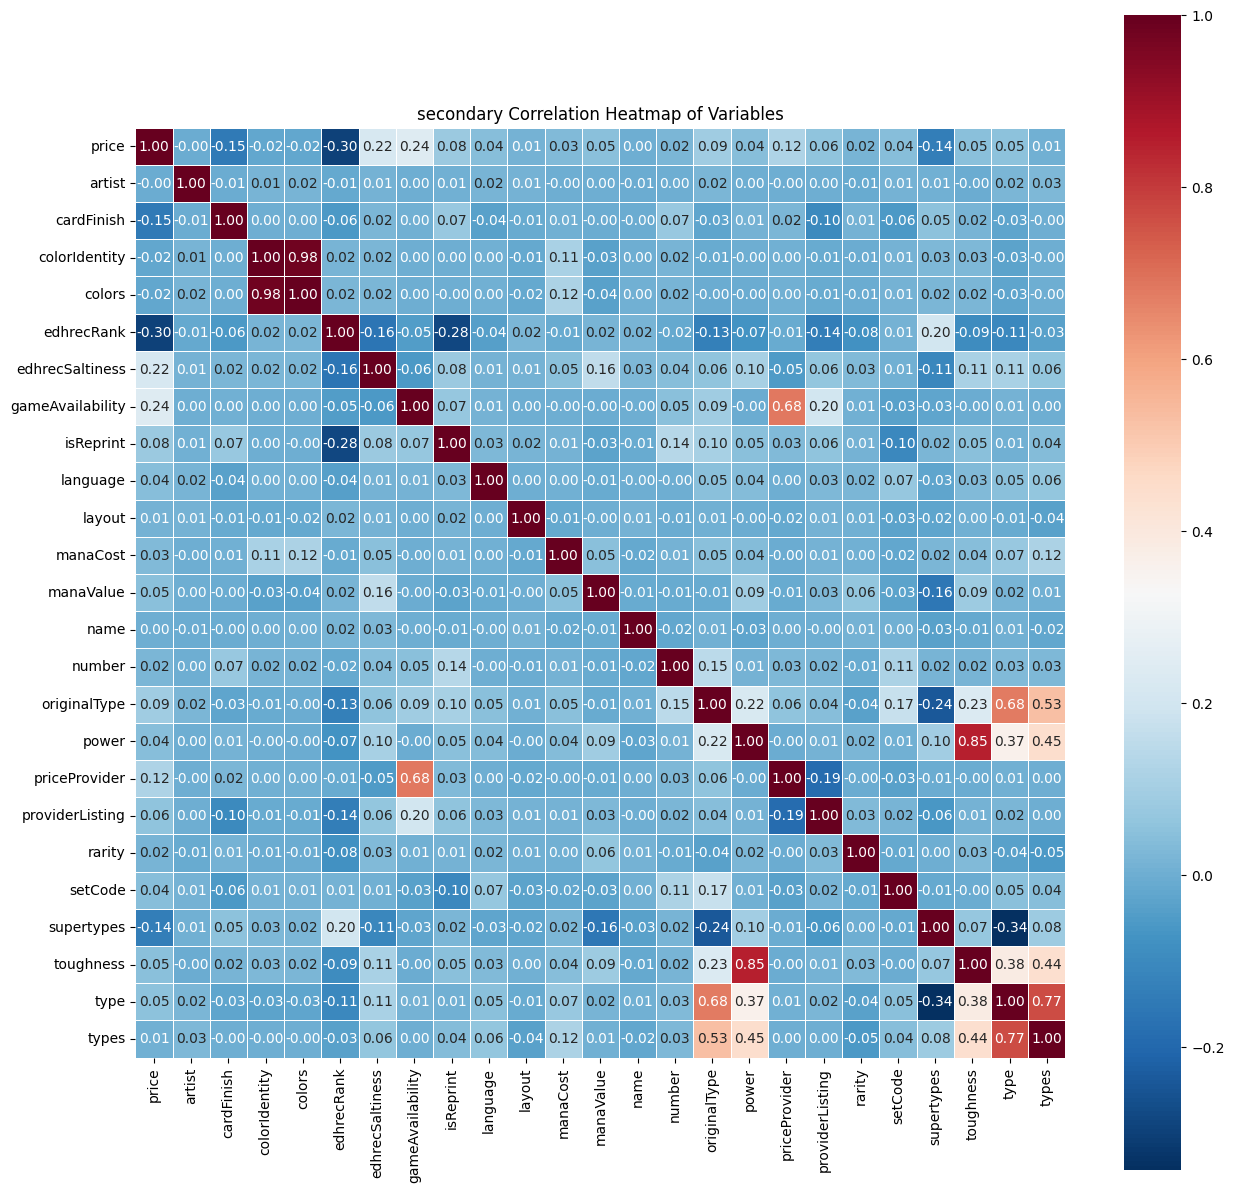

In [10]:
corr(data, dataset)


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = data.copy()
# Define a function to calculate VIF
def calculate_vif(df):
    # Adding a constant for intercept
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF
vif_results = calculate_vif(df.drop(columns='price'))  # Drop the dependent variable
print("Variance Inflation Factor (VIF) results:")

# Identify features with high VIF
high_vif = vif_results[vif_results['VIF'] > 10]  # or 5 based on context
print("\nFeatures with high VIF (> 10):")
print(high_vif)

Variance Inflation Factor (VIF) results:

Features with high VIF (> 10):
         feature         VIF
0          const  243.812157
3  colorIdentity   26.922122
4         colors   26.931672


Original skewness: 2.0777525736345335
Square Root skewness: 1.1214983436053272
Inverse skewness: 3.0061944433522036
Box-Cox skewness: 0.31754573903010114
Yeo-Johnson skewness: 0.3175457509434511


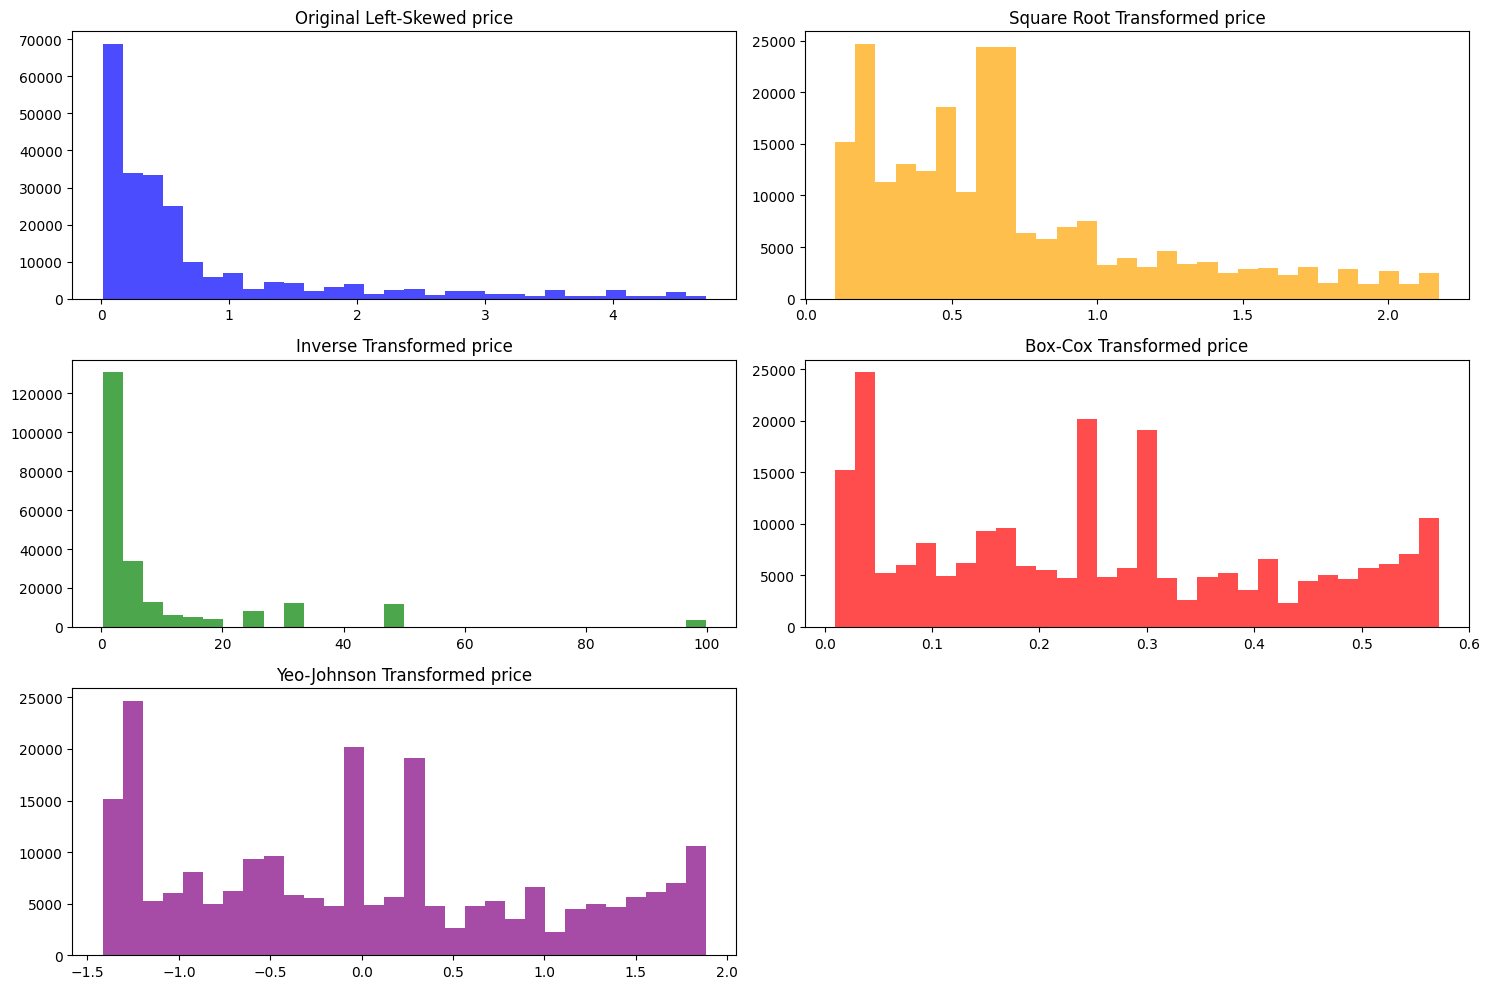

In [12]:
## transform data for normalcy 
df = data.copy()


import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer


def transforms (df, col):
    df['square_root_transformed'] = np.sqrt(df[col])
    df['inverse_transformed'] = 1 / (df[col] + 1e-5)  # Adding a small value to avoid division by zero
    df['boxcox_transformed'], _ = stats.boxcox(df[col] + 1)  # Adding 1 to handle zeros
    pt = PowerTransformer(method='yeo-johnson')
    df['yeo_transformed'] = pt.fit_transform(df[[col]])

    skewness = {
        'Original': df[col].skew(),
        'Square Root': df['square_root_transformed'].skew(),
        'Inverse': df['inverse_transformed'].skew(),
        'Box-Cox': df['boxcox_transformed'].skew(),
        'Yeo-Johnson': df['yeo_transformed'].skew(),
    }

    for transform, skew in skewness.items():
        print(f'{transform} skewness: {skew}')

    # Visualize the transformed data
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.hist(df[col], bins=30, alpha=0.7, color='blue')
    plt.title(f'Original Left-Skewed {col}')

    plt.subplot(3, 2, 2)
    plt.hist(df['square_root_transformed'], bins=30, alpha=0.7, color='orange')
    plt.title(f'Square Root Transformed {col}')

    plt.subplot(3, 2, 3)
    plt.hist(df['inverse_transformed'], bins=30, alpha=0.7, color='green')
    plt.title(f'Inverse Transformed {col}')

    plt.subplot(3, 2, 4)
    plt.hist(df['boxcox_transformed'], bins=30, alpha=0.7, color='red')
    plt.title(f'Box-Cox Transformed {col}')

    plt.subplot(3, 2, 5)
    plt.hist(df['yeo_transformed'], bins=30, alpha=0.7, color='purple')
    plt.title(f'Yeo-Johnson Transformed {col}')

    plt.tight_layout()
    plt.show()

    return df

price = transforms(df,'price')

Original skewness: 0.516758773844703
Square Root skewness: -0.10542944288730692
Inverse skewness: 27.761915554956353
Box-Cox skewness: -0.21367313858641496
Yeo-Johnson skewness: -0.21367313802988314


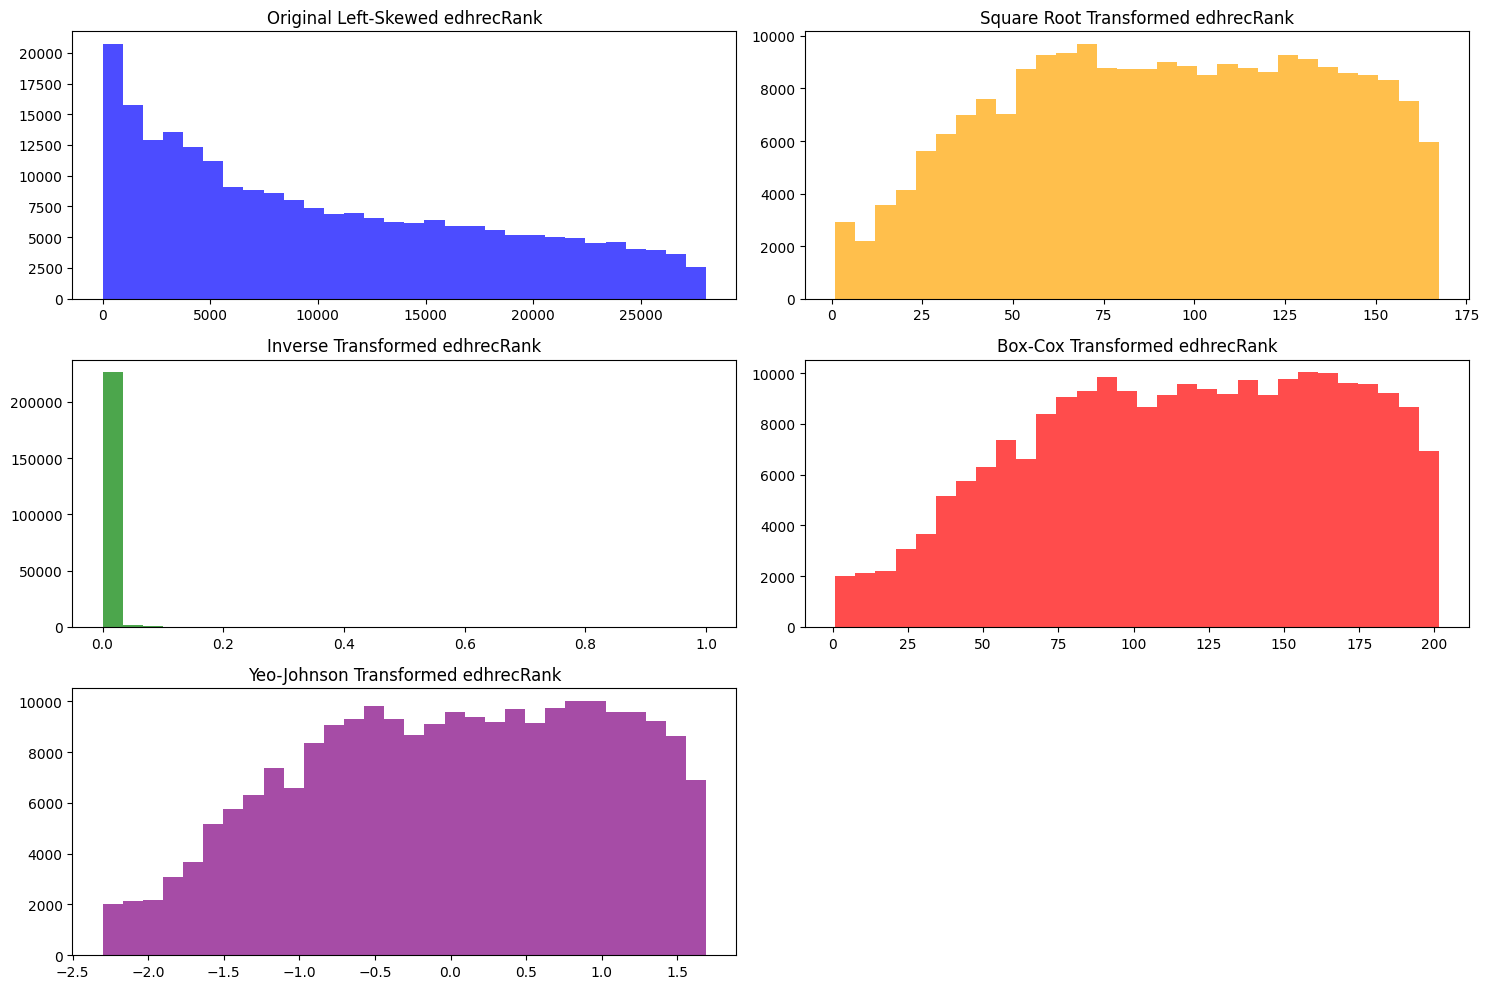

Original skewness: 2.551911988642195
Square Root skewness: 1.1043078139230864
Inverse skewness: 5.92291343922691
Box-Cox skewness: 0.21533214511501866
Yeo-Johnson skewness: 0.21533218317695288


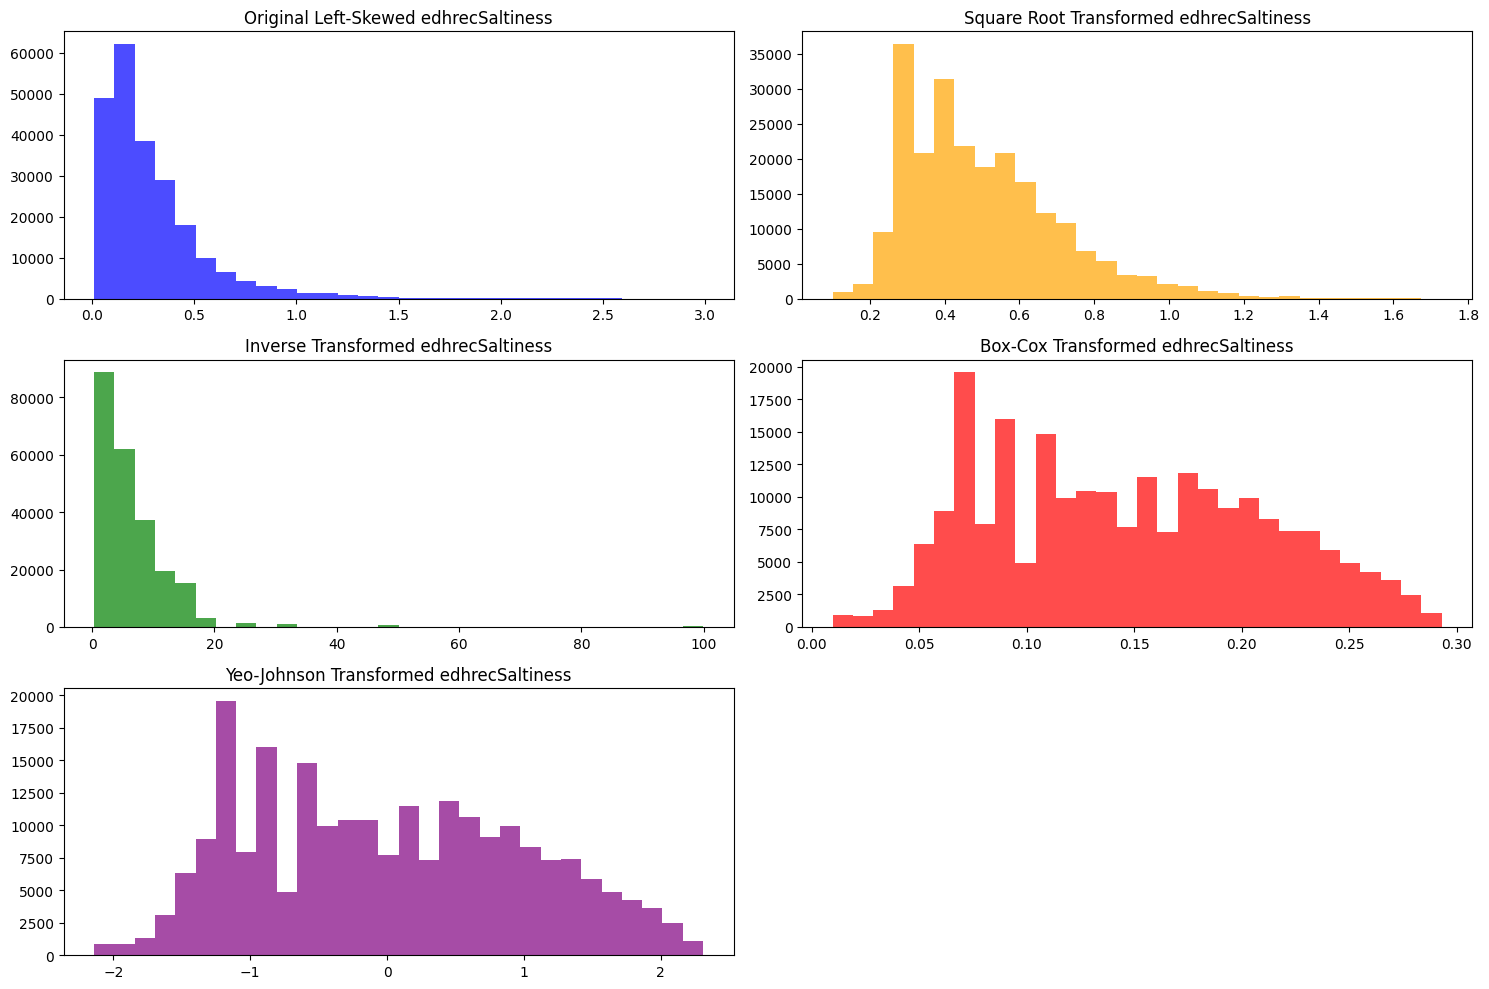

In [13]:
transform = data.copy()
transform['price'] = price['boxcox_transformed']

edr = transforms(df,'edhrecRank')
transform['price'] = edr['boxcox_transformed']

eds = transforms(df,'edhrecSaltiness')
transform['price'] = eds['boxcox_transformed']

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = data.copy()
# Define a function to calculate VIF
def calculate_vif(df):
    # Adding a constant for intercept
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF
vif_results = calculate_vif(df.drop(columns='price'))  # Drop the dependent variable
print("Variance Inflation Factor (VIF) results:")

# Identify features with high VIF
high_vif = vif_results[vif_results['VIF'] > 10]  # or 5 based on context
print("\nFeatures with high VIF (> 10):")
print(high_vif)

Variance Inflation Factor (VIF) results:

Features with high VIF (> 10):
         feature         VIF
0          const  243.812157
3  colorIdentity   26.922122
4         colors   26.931672


In [15]:
# drop primary colorIdentity
data = data.drop(columns='colorIdentity')

Original skewness: 2.0777525736345335
Square Root skewness: 1.1214983436053272
Inverse skewness: 3.0061944433522036
Box-Cox skewness: 0.31754573903010114
Yeo-Johnson skewness: 0.3175457509434511


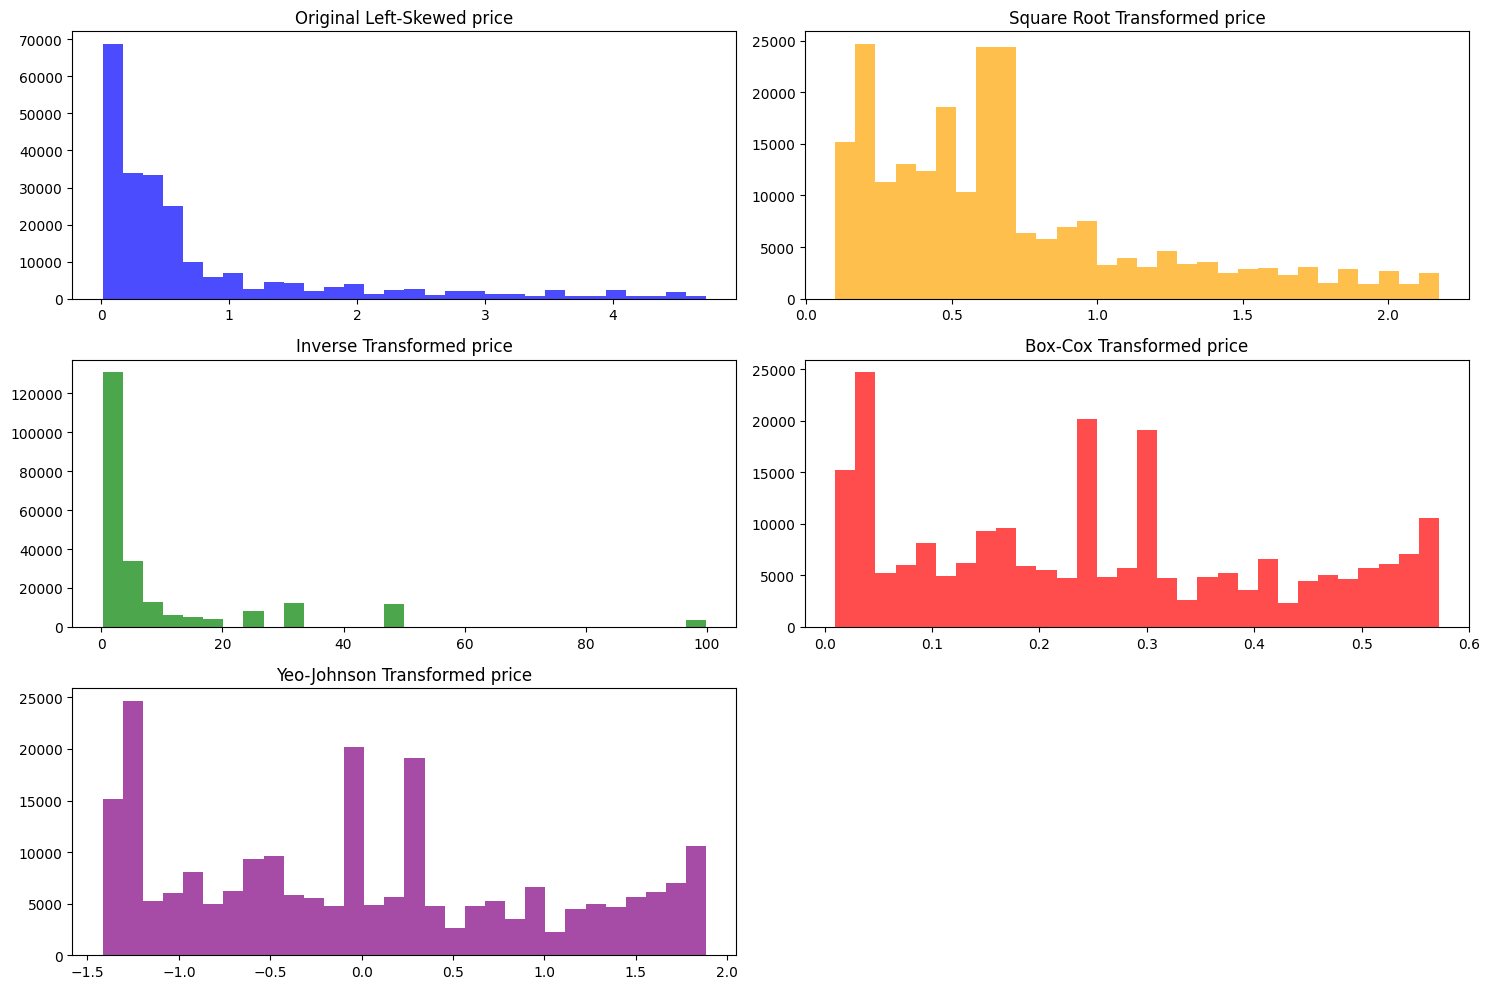

In [16]:
## transform data for normalcy 
df = data.copy()


import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer


def transforms (df, col):
    df['square_root_transformed'] = np.sqrt(df[col])
    df['inverse_transformed'] = 1 / (df[col] + 1e-5)  # Adding a small value to avoid division by zero
    df['boxcox_transformed'], _ = stats.boxcox(df[col] + 1)  # Adding 1 to handle zeros
    pt = PowerTransformer(method='yeo-johnson')
    df['yeo_transformed'] = pt.fit_transform(df[[col]])

    skewness = {
        'Original': df[col].skew(),
        'Square Root': df['square_root_transformed'].skew(),
        'Inverse': df['inverse_transformed'].skew(),
        'Box-Cox': df['boxcox_transformed'].skew(),
        'Yeo-Johnson': df['yeo_transformed'].skew(),
    }

    for transform, skew in skewness.items():
        print(f'{transform} skewness: {skew}')

    # Visualize the transformed data
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.hist(df[col], bins=30, alpha=0.7, color='blue')
    plt.title(f'Original Left-Skewed {col}')

    plt.subplot(3, 2, 2)
    plt.hist(df['square_root_transformed'], bins=30, alpha=0.7, color='orange')
    plt.title(f'Square Root Transformed {col}')

    plt.subplot(3, 2, 3)
    plt.hist(df['inverse_transformed'], bins=30, alpha=0.7, color='green')
    plt.title(f'Inverse Transformed {col}')

    plt.subplot(3, 2, 4)
    plt.hist(df['boxcox_transformed'], bins=30, alpha=0.7, color='red')
    plt.title(f'Box-Cox Transformed {col}')

    plt.subplot(3, 2, 5)
    plt.hist(df['yeo_transformed'], bins=30, alpha=0.7, color='purple')
    plt.title(f'Yeo-Johnson Transformed {col}')

    plt.tight_layout()
    plt.show()

    return df

price = transforms(df,'price')

Original skewness: 0.516758773844703
Square Root skewness: -0.10542944288730692
Inverse skewness: 27.761915554956353
Box-Cox skewness: -0.21367313858641496
Yeo-Johnson skewness: -0.21367313802988314


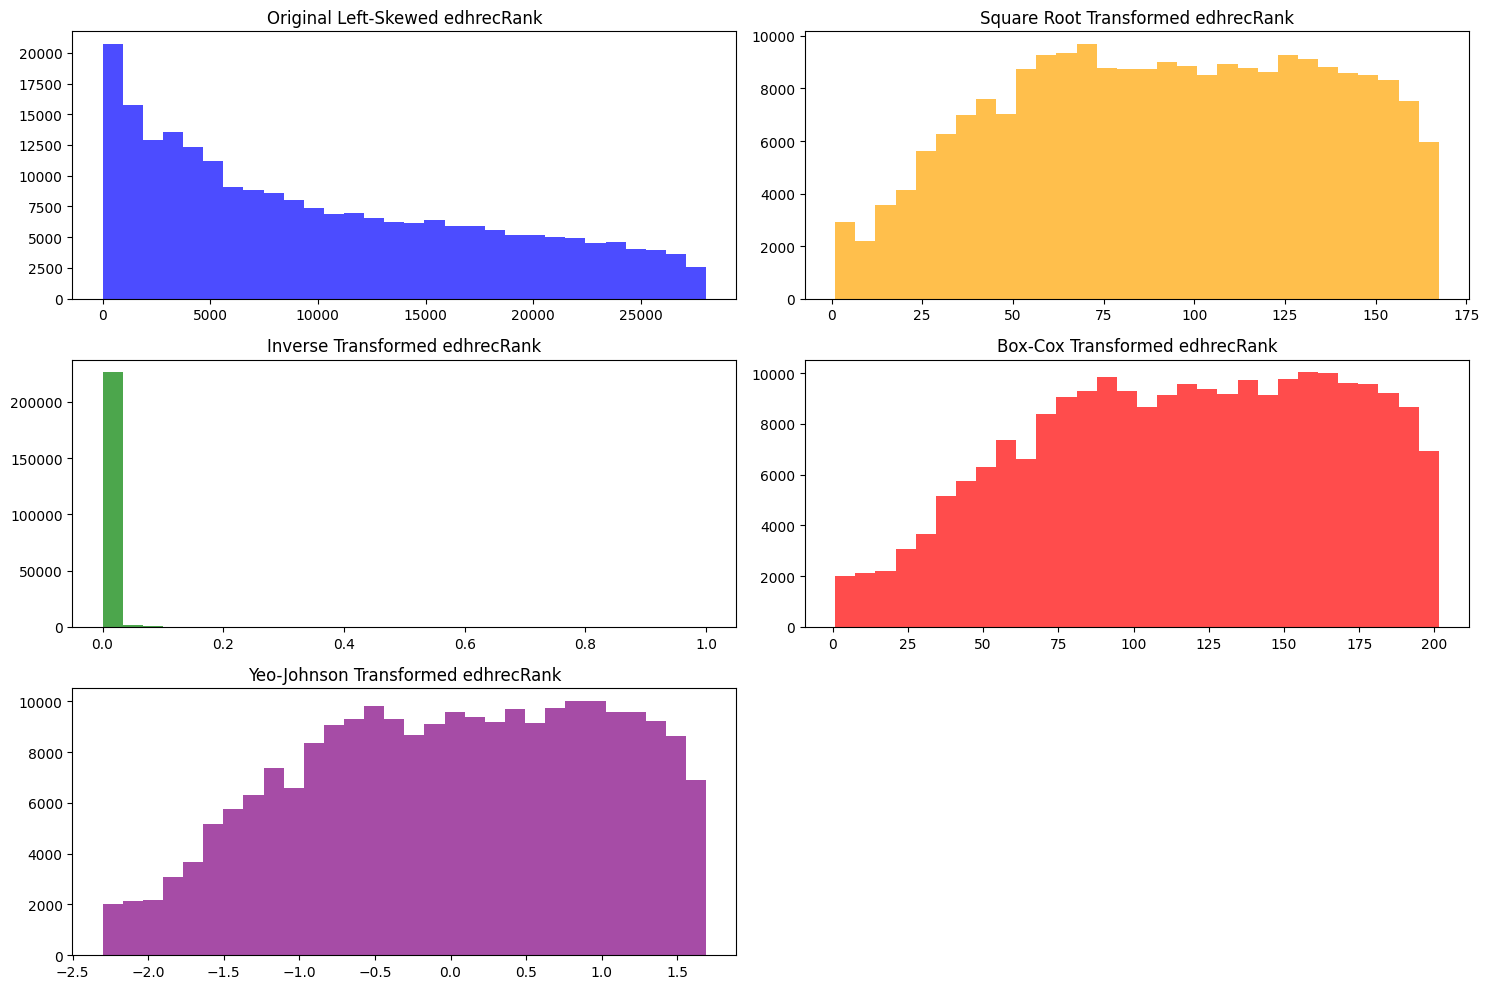

Original skewness: 2.551911988642195
Square Root skewness: 1.1043078139230864
Inverse skewness: 5.92291343922691
Box-Cox skewness: 0.21533214511501866
Yeo-Johnson skewness: 0.21533218317695288


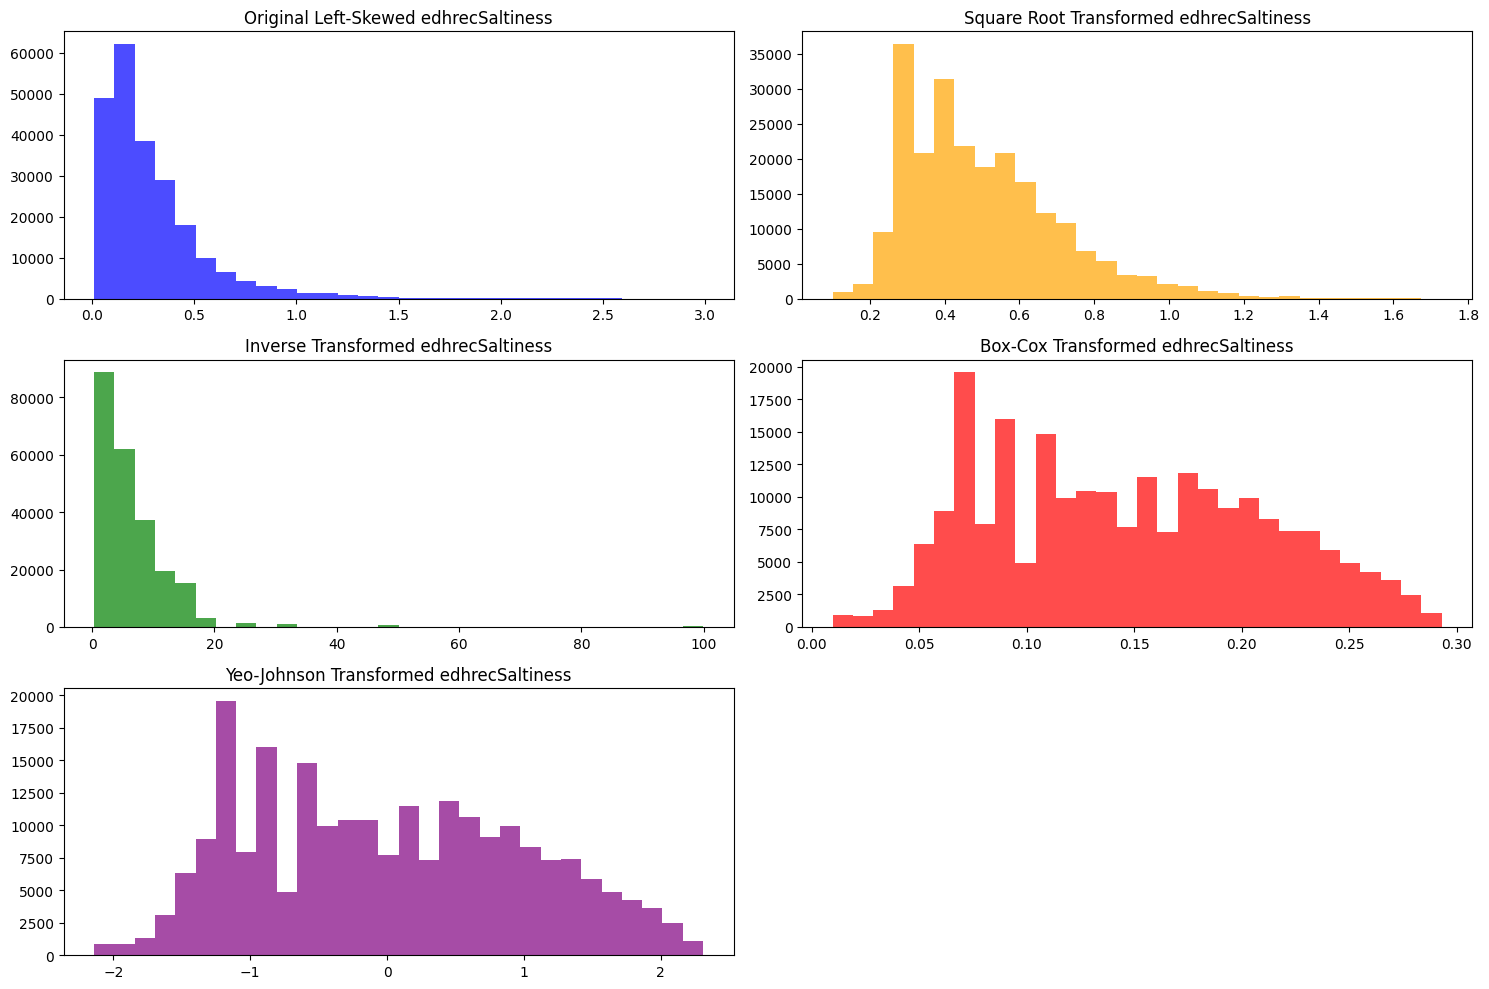

In [17]:
transform = data.copy()
transform['price'] = price['boxcox_transformed']

edr = transforms(df,'edhrecRank')
transform['price'] = edr['boxcox_transformed']

eds = transforms(df,'edhrecSaltiness')
transform['price'] = eds['boxcox_transformed']

In [18]:
# Initialize a results list
results = []

# Calculate t-scores and p-values for each independent variable
for col in df.columns:
    if col != 'price':
        t_stat, p_value = stats.ttest_ind(df[col], df['price'], equal_var=False)  # Welch's t-test
        results.append({'Variable': col, 'T-score': t_stat, 'P-value': p_value})

# Create a results DataFrame
results_df = pd.DataFrame(results)

print(f"Secondary Dataset Results: \n {results_df.to_string(index=False)}")

Secondary Dataset Results: 
                Variable     T-score       P-value
                 artist  800.471980  0.000000e+00
             cardFinish  409.419464  0.000000e+00
                 colors  848.585308  0.000000e+00
             edhrecRank  622.054171  0.000000e+00
        edhrecSaltiness -205.092953  0.000000e+00
       gameAvailability   29.658054 5.119910e-193
              isReprint -106.482666  0.000000e+00
               language  590.618660  0.000000e+00
                 layout 2345.247354  0.000000e+00
               manaCost  668.759183  0.000000e+00
              manaValue  650.367138  0.000000e+00
                   name  823.969217  0.000000e+00
                 number  656.399831  0.000000e+00
           originalType  985.763186  0.000000e+00
                  power 1131.055230  0.000000e+00
          priceProvider  248.340464  0.000000e+00
        providerListing -268.418148  0.000000e+00
                 rarity  584.873268  0.000000e+00
                setCo

In [19]:
# Initialize a results list
results = []

# Calculate t-scores and p-values for each independent variable
for col in transform.columns:
    if col != 'price':
        t_stat, p_value = stats.ttest_ind(df[col], df['price'], equal_var=False)  # Welch's t-test
        results.append({'Variable': col, 'T-score': t_stat, 'P-value': p_value})

# Create a results DataFrame
results_df = pd.DataFrame(results)

print(f"Primary Dataset Results: \n{results_df.to_string(index=False)}")

Primary Dataset Results: 
        Variable     T-score       P-value
          artist  800.471980  0.000000e+00
      cardFinish  409.419464  0.000000e+00
          colors  848.585308  0.000000e+00
      edhrecRank  622.054171  0.000000e+00
 edhrecSaltiness -205.092953  0.000000e+00
gameAvailability   29.658054 5.119910e-193
       isReprint -106.482666  0.000000e+00
        language  590.618660  0.000000e+00
          layout 2345.247354  0.000000e+00
        manaCost  668.759183  0.000000e+00
       manaValue  650.367138  0.000000e+00
            name  823.969217  0.000000e+00
          number  656.399831  0.000000e+00
    originalType  985.763186  0.000000e+00
           power 1131.055230  0.000000e+00
   priceProvider  248.340464  0.000000e+00
 providerListing -268.418148  0.000000e+00
          rarity  584.873268  0.000000e+00
         setCode  654.309904  0.000000e+00
      supertypes  401.622635  0.000000e+00
       toughness 1268.420404  0.000000e+00
            type  828.734928

In [20]:
print(transform)

transform.to_csv('../dataset/transform_secondary.csv', index = False)

           price  artist  cardFinish  colors  edhrecRank  edhrecSaltiness  \
0       0.209563     813           2      29     10512.0             0.44   
1       0.220675      56           2      25      6705.0             0.50   
2       0.156677     574           2      17     25046.0             0.25   
3       0.182993     337           2       0     23391.0             0.33   
4       0.152848    1106           2      16      1337.0             0.24   
...          ...     ...         ...     ...         ...              ...   
228632  0.094143     487           1      17       128.0             0.12   
228633  0.283761    1181           2      29       347.0             1.58   
228634  0.215367     596           2      17       602.0             0.47   
228635  0.215367     596           2      17       602.0             0.47   
228636  0.215367     596           2      17       602.0             0.47   

        gameAvailability  isReprint  language  layout  ...  originalType  \